In [1]:
from tqdm.auto import trange
import numpy as np
import cupy as cp
import pathlib
import sys

In [2]:
sys.path.append(str(pathlib.Path('../').resolve()))

In [3]:
from lib.utils.data import Dataset, shuffle_dataset, load_integer_dataset
from lib.utils.enums import Initialization, NonLinearity, OptimizerName
from lib.utils.nn import accuracy, plot_history, l2_loss
from lib.experiments import build_augmentation_pipeline
from lib.utils.train import train_step_local, val_step
from lib.utils.misc import to_cpu

# Experiment config

In [4]:
num_fc_layers = 5
num_fc_hidden = [512, 256, 128, 64]

In [5]:
dataset_config = dict(
    dataset=Dataset.FASHION_MNIST.name,
    subsample_ratio=1.0,
    ohe_values=(0, 32),
    add_padding=False,
    normalize=True,
    data_augmentation=True,
)

In [6]:
network_config = dict(
    num_fc_layers=num_fc_layers,
    num_fc_hidden=num_fc_hidden,
    non_linearity=NonLinearity.NITRO_LEAKY_RELU.name,
    init=Initialization.UNIFORM_KAIMING_LEAKY_RELU.name,
    dtype='int32',
    device='cuda',
    local_loss='pred',
    dropout_rate=0.0,
    seed=42,
    bias=False,
    debug=False,
)

In [7]:
training_config = dict(
    batch_size=64,
    num_epochs=35,
    lr_inv=512,
    lr_amp_factor=None,
    fwd_decay_inv=10_000,
    subnet_decay_inv=1_000,
    optimizer=OptimizerName.INTEGER_SGD.name,
)

In [8]:
config = dataset_config | network_config | training_config

In [9]:
# Setup reproducibility
np.random.seed(config["seed"])
cp.random.seed(config["seed"])

# Data

Training on 50000 samples
Data normalized. New statistics:
-  Min: -46
-  Max: 112
- Mean: 0
-  Std: 55

Moved data to device: <CUDA Device 0>
Train set:  (50000, 1, 28, 28), (50000, 10)
Val set:    (10000, 1, 28, 28), (10000, 10)
Test set:   (10000, 1, 28, 28), (10000, 10)
Data types: (int8, int8)


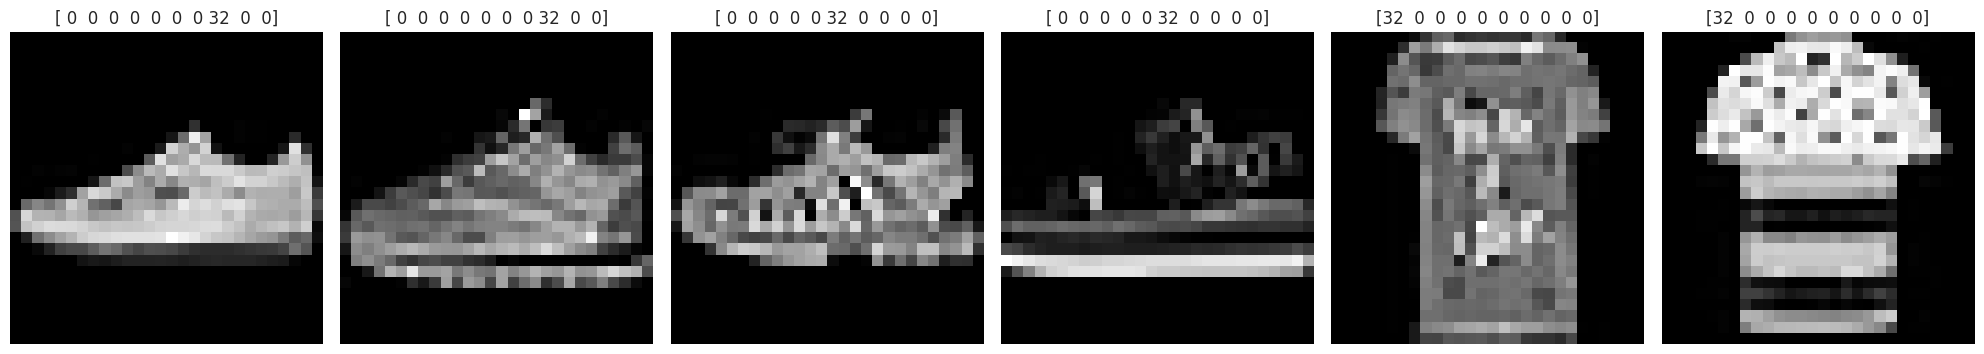

In [10]:
X_train, X_val, X_test, y_train, y_val, y_test = load_integer_dataset(config, add_padding=False, ohe_values=(0, 32))

In [11]:
# Configure data augmentation
augmentation_pipeline = build_augmentation_pipeline(config)
print(augmentation_pipeline)

AugmentationPipeline([
    RandomCrop(size=28, padding=2, probability=0.5)
    RandomHorizontalFlip(probability=0.5)
])


# Network

In [12]:
from lib.models.local_loss_models import IntegerLocalLossMLP

In [13]:
np.random.seed(config['seed'])
cp.random.seed(config['seed'])
model = IntegerLocalLossMLP(
    num_fc_layers=config['num_fc_layers'],
    num_fc_hidden=config['num_fc_hidden'],
    num_classes=y_train.shape[1],
    input_dim=X_train.shape[1] * X_train.shape[2] * X_train.shape[3],
    local_loss=config['local_loss'],
    dtype=config['dtype'],
    dropout_rate=config['dropout_rate'],
    non_linearity=NonLinearity[config['non_linearity']],
    init=Initialization[config['init']],
    fwd_decay_inv=config['fwd_decay_inv'],
    subnet_decay_inv=config['subnet_decay_inv'],
    device=config['device'],
    bias=config['bias'],
    debug=config['debug'],
    optimizer=OptimizerName[config['optimizer']],
    lr_amp_factor=config['lr_amp_factor'],
)
print(model.extra_repr(1))

IntegerLocalLossMLP(
	(0): Sequential(
			(0): Flatten()
			(1): LocalLinearBlock(
			(0): IntegerLinear(in_features=784, out_features=512, bias=False, decay_rate_inv=10000)
			(1): ConstantScaling(fwd_factor=200704, bwd_factor=1)
			(2): NitroLeakyReLU(negative_slope_inv=4)
			(learning_layers): Sequential(
			(0): IntegerLinear(in_features=512, out_features=10, bias=False, decay_rate_inv=1000)
			(1): ConstantScaling(fwd_factor=131072, bwd_factor=1)
		)
	)
			(2): LocalLinearBlock(
			(0): IntegerLinear(in_features=512, out_features=256, bias=False, decay_rate_inv=10000)
			(1): ConstantScaling(fwd_factor=131072, bwd_factor=1)
			(2): NitroLeakyReLU(negative_slope_inv=4)
			(learning_layers): Sequential(
			(0): IntegerLinear(in_features=256, out_features=10, bias=False, decay_rate_inv=1000)
			(1): ConstantScaling(fwd_factor=65536, bwd_factor=1)
		)
	)
			(3): LocalLinearBlock(
			(0): IntegerLinear(in_features=256, out_features=128, bias=False, decay_rate_inv=10000)
			(1): Constan

In [14]:
model.print_layers_parameters()

Layer: linear_encoder_00
- Weights:
[[ -8   9 -10 ...  -4   3   4]
 [  4   3  -7 ...   7 -10 -10]
 [  2  -3  -7 ...   5  -5  -6]
 ...
 [  6   9 -10 ...  -8  -7   4]
 [  0   4  -4 ...  -5   0  -2]
 [  7  -1   3 ...  -3   2   0]]
Layer: linear_pred_00
- Weights:
[[ -7  -1 -11 ...  -1  -5 -11]
 [  5   8 -10 ...  -6   7  -9]
 [  0  11  13 ... -12   0  -5]
 ...
 [-13  -8  -5 ...   5  -3  -5]
 [-13  -7 -10 ...  12  -8  -3]
 [ 11  -9   1 ...  -4  -5   4]]
Layer: linear_encoder_01
- Weights:
[[  7  -9  12 ...   6   0  13]
 [ -1 -11 -13 ...  10  -6  -2]
 [ -4   4  11 ...  -8  11  -6]
 ...
 [ 11  -1  10 ...  -6   8   1]
 [ 10 -13  13 ...   5   7  13]
 [ -8   8  -6 ...   4  -6  13]]
Layer: linear_pred_01
- Weights:
[[-10  17 -14 ...  11  17 -18]
 [-15  -1   2 ...   1 -19  14]
 [ 19  18   8 ...  -6  -8 -17]
 ...
 [  1   2 -15 ...  19 -15   0]
 [-18   7  17 ... -12   1  -4]
 [  2  -7 -14 ...   5   3 -14]]
Layer: linear_encoder_02
- Weights:
[[-12  -8   4 ... -18   3  -5]
 [  9  -8  14 ...  16   7 -

# Training

In [15]:
from lib.optim.lr_schedulers import ConstantLR
from lib.utils.nn import EarlyStopping, ReduceLROnPlateau

In [16]:
lr_scheduler = ConstantLR(config['lr_inv'])
early_stopping = EarlyStopping(min_delta=0.01, patience=25, from_epoch=10)
reduce_lr_plateau = ReduceLROnPlateau(factor=2, min_delta=0.01, patience=15, from_epoch=10)

In [17]:
n_train_batches = len(X_train) // config['batch_size']
n_val_batches = len(X_val) // config['batch_size']
last_epoch = 0

xp = cp.get_array_module(X_train)
loss_history = xp.empty(config['num_epochs'])
acc_history = xp.empty(config['num_epochs'])
val_loss_history = xp.empty(config['num_epochs'])
val_acc_history = xp.empty(config['num_epochs'])

for epoch in trange(config['num_epochs']):
    # Train and validation loops
    lr_scheduler.step()
    X_train, y_train = shuffle_dataset(X_train, y_train)
    
    loss_history[epoch], acc_history[epoch], local_losses, local_accuracies = train_step_local(
        model=model,
        X_train=X_train,
        y_train=y_train,
        batch_size=config['batch_size'],
        n_train_batches=n_train_batches,
        augmentation_pipeline=augmentation_pipeline,
        lr_inv=lr_scheduler.get_lr()
    )
    
    val_loss_history[epoch], val_acc_history[epoch] = val_step(
        model=model, 
        X_val=X_val, 
        y_val=y_val, 
        batch_size=config['batch_size'], 
        n_val_batches=n_val_batches
    )
    
    last_epoch = epoch

    if epoch % 3 == 0:
        print(f"Epoch {epoch}:")
        for i, (local_loss, local_acc) in enumerate(zip(local_losses, local_accuracies)):
            print(f"- Local accuracy {i}: {local_acc:.2%}")
        print(f"- Output accuracy: {acc_history[epoch]:.2%}")
        print(f"- Output val accuracy: {val_acc_history[epoch]:.2%}")
        print("\n")

    # Early stopping
        if early_stopping.early_stop(float(val_acc_history[epoch])):
            print(f"{'-' * 64}\nEarly stopping at epoch {epoch + 1}\n{'-' * 64}")
            break

    # ReduceLROnPlateau
    if reduce_lr_plateau.reduce_lr(float(val_acc_history[epoch])):
        lr_scheduler.set_lr(lr_scheduler.get_lr() * reduce_lr_plateau.factor)
        print(f"{'-' * 64}\nReducing learning rate on plateau at epoch {epoch + 1}\n{'-' * 64}")
    
print(f'Final train loss: {loss_history[last_epoch]:.5f}')
print(f'Final train accuracy: {acc_history[last_epoch]:.2%}')
print(f'Final validation loss: {val_loss_history[last_epoch]:.5f}')
print(f'Final validation accuracy: {val_acc_history[last_epoch]:.2%}')

  0%|          | 0/35 [00:00<?, ?it/s]

Epoch 0:
- Local accuracy 0: 49.63%
- Local accuracy 1: 29.33%
- Local accuracy 2: 19.01%
- Local accuracy 3: 12.18%
- Output accuracy: 12.23%
- Output val accuracy: 20.65%


Epoch 3:
- Local accuracy 0: 75.80%
- Local accuracy 1: 75.44%
- Local accuracy 2: 74.21%
- Local accuracy 3: 73.86%
- Output accuracy: 73.86%
- Output val accuracy: 76.72%


Epoch 6:
- Local accuracy 0: 78.41%
- Local accuracy 1: 78.80%
- Local accuracy 2: 78.67%
- Local accuracy 3: 78.59%
- Output accuracy: 78.59%
- Output val accuracy: 82.24%


Epoch 9:
- Local accuracy 0: 79.76%
- Local accuracy 1: 80.29%
- Local accuracy 2: 80.30%
- Local accuracy 3: 80.28%
- Output accuracy: 80.28%
- Output val accuracy: 83.60%


Epoch 12:
- Local accuracy 0: 80.93%
- Local accuracy 1: 81.75%
- Local accuracy 2: 81.70%
- Local accuracy 3: 81.70%
- Output accuracy: 81.69%
- Output val accuracy: 84.48%


Epoch 15:
- Local accuracy 0: 81.65%
- Local accuracy 1: 82.62%
- Local accuracy 2: 82.68%
- Local accuracy 3: 82.66%
- Outp

In [18]:
y_subnets = model.subnetworks_predict(X_test)
for i, y_subnet in enumerate(y_subnets):
    subnet_acc = accuracy(y_test, y_subnet)
    print(f'Local Val Accuracy {i}: {subnet_acc:.2%}')

Local Val Accuracy 0: 85.68%
Local Val Accuracy 1: 86.54%
Local Val Accuracy 2: 86.63%
Local Val Accuracy 3: 86.71%


In [19]:
loss_history, val_loss_history = loss_history[:last_epoch + 1], val_loss_history[:last_epoch + 1]
acc_history, val_acc_history = acc_history[:last_epoch + 1], val_acc_history[:last_epoch + 1]

if config['device'] == 'cuda':
    # Move training statistics to the CPU
    loss_history, val_loss_history = to_cpu(loss_history), to_cpu(val_loss_history)
    acc_history, val_acc_history = to_cpu(acc_history), to_cpu(val_acc_history)

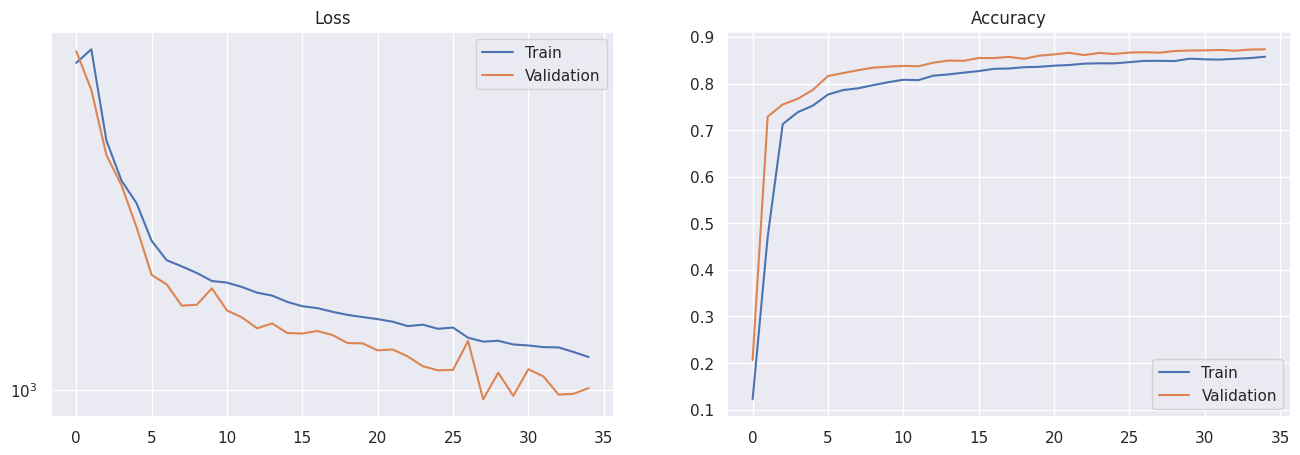

In [20]:
plot_history(loss_history, val_loss_history, acc_history, val_acc_history, log_scale=True)

In [21]:
y_pred = model.predict(X_test, progress_bar=False)
test_loss = l2_loss(y_test, y_pred)
test_acc = accuracy(y_test, y_pred)
print(f'Test accuracy: {test_acc:.2%}')

Test accuracy: 86.72%
